In [1]:
# prompt: write code for google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# ⚡ Quick Setup - Run after runtime reset (CPU/GPU Switch)
# Installs essential packages silently to save output clutter

!pip install torch pytorch-forecasting pytorch-lightning \
    rich colorama matplotlib seaborn pandas numpy tensorboard \
    'lightning[extra]' pyarrow fastparquet --quiet

print("\033[92m✅ All required packages installed successfully.\033[0m")

✅ All required packages installed successfully.


In [13]:
# Standard Library
import os
import glob
import json
import shutil
from concurrent.futures import ThreadPoolExecutor

# Third-Party Libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

# PyTorch Lightning
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# PyTorch Forecasting
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE

In [14]:
import os

parquet_path = "/content/drive/MyDrive/datasets/processed/FeatureEngcolab"

# List all VM partitions (folder names)
vm_folders = sorted([
    name.split('=')[1] for name in os.listdir(parquet_path) if name.startswith("VM=")
])

print(f"Available VMs: {vm_folders[:10]} ... Total: {len(vm_folders)}")

Available VMs: ['1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006'] ... Total: 1250


In [5]:
# Load First N VMs Dynamically [100, 250, 500, 750, 1000, 1250]

for N in [30]:
    selected_vms = vm_folders[:N]

    df3 = dd.read_parquet(
        parquet_path,
        filters=[("VM", "in", selected_vms)]
    ).compute()

    print(f"✅ Loaded {N} VMs → Shape: {df3.shape}")

    # Optionally: Run model here

✅ Loaded 30 VMs → Shape: (264533, 50)


In [6]:
print(df3.columns.tolist())

['Timestamp [s]', 'CPU cores', 'CPU capacity provisioned [MHZ]', 'CPU usage [MHZ]', 'CPU usage [%]', 'Memory capacity provisioned [KB]', 'Memory usage [KB]', 'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]', 'Timestamp', 'time_idx', 'time_diff', 'hour', 'dayofweek', 'is_weekend', 'month', 'day', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'cpu_utilization_ratio', 'memory_utilization_ratio', 'cpu_util_percent', 'memory_util_percent', 'cpu_util_prev', 'cpu_util_diff', 'memory_util_prev', 'memory_util_diff', 'disk_total_throughput', 'disk_rolling_mean', 'disk_rolling_std', 'network_total_throughput', 'network_rolling_mean', 'network_rolling_std', 'disk_read_prev', 'disk_read_diff', 'disk_write_prev', 'disk_write_diff', 'network_received_prev', 'network_received_diff', 'network_transmitted_prev', 'network_transmitted_diff', 'network_total_prev', 'network_total

In [7]:
df3 = df3.rename(columns={'VM': 'vm_id'})

tft_df = df3.dropna(subset=[
    'cpu_utilization_ratio',
    'memory_utilization_ratio',
    'disk_total_throughput',
    'network_total_throughput'
])

tft_df = tft_df.compute() if 'dask' in str(type(tft_df)) else tft_df

In [8]:
# Define target variables
# targets = ['cpu_utilization_ratio', 'memory_utilization_ratio', 'disk_total_throughput', 'network_total_throughput']

In [9]:
# Unified config — modify only here
train_config = {
    "targets": ['cpu_utilization_ratio'],
    "time_varying_known_reals": ['time_idx', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos'],
    "group_ids": ['vm_id'],
    "max_encoder_length": 30,
    "max_prediction_length": 6,
    "hidden_size": 8,
    "dropout": 0.1,
    "learning_rate": 0.01,
    "batch_size": 64,
    "num_workers": 2,
    "epochs": 2,
    "loss_fn": RMSE(),
    "output_base_dir": "/content/drive/MyDrive/output",
    "log_dir": "/content/drive/MyDrive/output/logs"
}

# Ensure output folders exist
os.makedirs(train_config["output_base_dir"], exist_ok=True)
os.makedirs(train_config["log_dir"], exist_ok=True)

In [10]:
val_df = tft_df[tft_df.time_idx > tft_df['time_idx'].max() * 0.8]
print(f"Validation data points: {len(val_df)}")
print(f"Minimum required: {train_config['max_encoder_length'] + train_config['max_prediction_length']}")

Validation data points: 42999
Minimum required: 36


In [11]:
# Reset index (important for unique indexing)
tft_df = tft_df.reset_index(drop=True)

# Prepare TimeSeriesDataSet for training portion (80%)
dataset = TimeSeriesDataSet(
    tft_df[tft_df.time_idx <= tft_df['time_idx'].max() * 0.8],
    time_idx='time_idx',
    target=train_config["targets"][0],  # 'cpu_utilization_ratio' here
    group_ids=train_config["group_ids"],
    max_encoder_length=train_config["max_encoder_length"],
    max_prediction_length=train_config["max_prediction_length"],
    time_varying_known_reals=train_config["time_varying_known_reals"],
    time_varying_unknown_reals=train_config["targets"],
    target_normalizer=GroupNormalizer(groups=train_config["group_ids"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# Validation dataset for prediction (no randomization, full data)
val_dataset = TimeSeriesDataSet.from_dataset(
    dataset, tft_df, predict=True, stop_randomization=True
)

# Create dataloaders

train_dataloader = dataset.to_dataloader(
    train=True,
    batch_size=train_config["batch_size"],
    num_workers=train_config["num_workers"]
)

val_dataloader = val_dataset.to_dataloader(
    train=False,
    batch_size=train_config["batch_size"],
    num_workers=train_config["num_workers"]
)


print(f"✅ Dataset and dataloaders ready. Train batches: {len(train_dataloader)}, Val batches: {len(val_dataloader)}")

✅ Dataset and dataloaders ready. Train batches: 2898, Val batches: 1


In [12]:
from pytorch_lightning.callbacks import EarlyStopping

for target in train_config["targets"]:
    print(f"\n🔁 Training for target: {target}")

    run_dir = os.path.join(train_config["output_base_dir"], f"{target}_run")
    os.makedirs(run_dir, exist_ok=True)

    # Save cleaned dataset snapshot for debugging
    tft_df.to_csv(f"{run_dir}/tft_df.csv", index=False)

    # Setup logging & checkpointing
    logger = CSVLogger(save_dir=train_config["log_dir"], name=f"{target}_log")

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath=run_dir,
        filename="tft-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        save_last=True,
        mode="min"
    )

    early_stopping = EarlyStopping(monitor="val_loss", patience=3, mode="min")


🔁 Training for target: cpu_utilization_ratio


,Timestamp [s],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],...,disk_read_diff,disk_write_prev,disk_write_diff,network_received_prev,network_received_diff,network_transmitted_prev,network_transmitted_diff,network_total_prev,network_total_diff,vm_id
0,1376314846,4,11703.99824,10912.027692,93.233333,67108864.0,6.129274e+06,0.133333,15981.600000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1376315146,4,11703.99824,10890.570362,93.050000,67108864.0,6.755624e+06,1.333333,19137.333333,0.000000,...,1.200000,15981.600000,3155.733333,0.000000,0.000000,2.133333,0.466667,2.133333,0.466667,1
2,1376315446,4,11703.99824,10434.114431,89.150000,67108864.0,8.947846e+06,2.533333,19974.933333,535.666667,...,1.200000,19137.333333,837.600000,0.000000,535.666667,2.600000,21.333333,2.600000,557.000000,1
3,1376315746,4,11703.99824,10539.450415,90.050000,67108864.0,1.879048e+07,5.466667,8791.800000,349.666667,...,2.933333,19974.933333,-11183.133333,535.666667,-186.000000,23.933333,-18.466667,559.600000,-204.466667,1
4,1376316046,4,11703.99824,10951.041020,93.566667,67108864.0,9.305761e+06,5.400000,15679.533333,0.000000,...,-0.066667,8791.800000,6887.733333,349.666667,-349.666667,5.466667,-3.400000,355.133333,-353.066667,1


In [20]:
# ckpt_path = os.path.join(run_dir, "tft-last.ckpt")

# if os.path.exists(ckpt_path):
#     print(f"📦 Resuming from checkpoint: {ckpt_path}")
#     model = TemporalFusionTransformer.load_from_checkpoint(
#         checkpoint_path=ckpt_path,
#         dataset=dataset,
#         loss=train_config["loss_fn"]
#     )
# else:
#     print("🆕 Starting new model")
#     model = TemporalFusionTransformer.from_dataset(
#         dataset,
#         learning_rate=train_config["learning_rate"],
#         hidden_size=train_config["hidden_size"],
#         dropout=train_config["dropout"],
#         loss=train_config["loss_fn"],
#         log_interval=10,
#         reduce_on_plateau_patience=4
#     )

# # ✅ Fixed indentation below:
# if torch.cuda.is_available():
#     accelerator = "gpu"
#     devices = 1
# else:
#     accelerator = "cpu"
#     devices = 1

# trainer = Trainer(
#     max_epochs=train_config["epochs"],
#     accelerator=accelerator,
#     devices=devices,
#     logger=logger,
#     callbacks=[checkpoint_callback, early_stopping],
#     enable_checkpointing=True
# )

# trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

import pytorch_lightning as pl

class TFTLightningModule(pl.LightningModule):
    def __init__(self, tft_model: TemporalFusionTransformer, learning_rate: float, loss_fn: torch.nn.Module):
        super().__init__()
        self.tft_model = tft_model
        self.learning_rate = learning_rate
        self.loss_fn = loss_fn

    def forward(self, x):
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat.prediction, y) # Extract prediction from output
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat.prediction, y) # Extract prediction from output
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Create the TFT model
tft_model = TemporalFusionTransformer.from_dataset(
    dataset,
    learning_rate=train_config["learning_rate"],
    hidden_size=train_config["hidden_size"],
    dropout=train_config["dropout"],
    loss=train_config["loss_fn"],
    log_interval=10,
    reduce_on_plateau_patience=4
)

# Wrap the TFT model in a LightningModule
model = TFTLightningModule(
    tft_model=tft_model,
    learning_rate=train_config["learning_rate"],
    loss_fn=train_config["loss_fn"]
)

# Setup Trainer
if torch.cuda.is_available():
    accelerator = "gpu"
    devices = 1
else:
    accelerator = "cpu"
    devices = 1

trainer = Trainer(
    max_epochs=train_config["epochs"],
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping],
    enable_checkpointing=True
)

# Fit the model
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 30. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [28]:
## ✅ Chunk 5 — Prediction, Visualization, Forecast Saving

In [23]:
# 🔍 Make raw predictions on validation set
predictions, x = model.tft_model.predict(val_dataloader, mode='raw', return_x=True)

# Extract forecast values as numpy array
forecast = predictions['prediction'][0].detach().cpu().numpy()

# 📈 Plot forecast using built-in visualization
plt.figure(figsize=(10, 6))
model.tft_model.plot_prediction(x, predictions, idx=0, show_future_observed=True)
plt.title(f"Prediction Plot for {target}")
plt.savefig(f"{run_dir}/plot.png")
plt.close()

print(f"✅ Prediction plot saved at: {run_dir}/plot.png")

# 💾 Save forecast to CSV
pd.DataFrame(forecast, columns=[f'{target}_forecast']).to_csv(f"{run_dir}/predictions.csv", index=False)
print(f"✅ Forecast values saved to: {run_dir}/predictions.csv")

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


ValueError: too many values to unpack (expected 2)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


AttributeError: 'dict' object has no attribute 'iget'

<Figure size 1000x600 with 0 Axes>

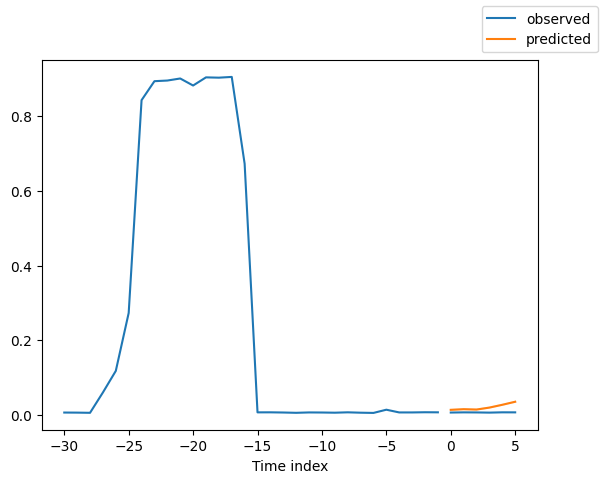

In [27]:
# 🔍 Make raw predictions on validation set
prediction_output = model.tft_model.predict(val_dataloader, mode='raw', return_x=True)

# Access predictions and x from the Prediction object
predictions = prediction_output.output # Access the output attribute which contains the prediction tensor
# The input batch 'x' is also contained within the Prediction object, often accessible directly or via an attribute
# Let's assume 'x' is directly accessible as an attribute for now, if not, we may need to inspect the object further.
# Based on the traceback, x is likely needed for plot_prediction. Let's try accessing it directly.
x = prediction_output.x # Assuming x is an attribute of the Prediction object

# Extract forecast values as numpy array
forecast = predictions.prediction[0].detach().cpu().numpy() # Access the 'prediction' attribute of the output

# 📈 Plot forecast using built-in visualization
plt.figure(figsize=(10, 6))
# The plot_prediction method expects the original input x and the predictions dictionary
# We need to reconstruct a predictions dictionary similar to what was expected before
predictions_dict = {'prediction': predictions.prediction} # Create a dictionary with the prediction tensor

model.tft_model.plot_prediction(x, predictions_dict, idx=0, show_future_observed=True)
plt.title(f"Prediction Plot for {target}")
plt.savefig(f"{run_dir}/plot.png")
plt.close()

print(f"✅ Prediction plot saved at: {run_dir}/plot.png")

# 💾 Save forecast to CSV
pd.DataFrame(forecast, columns=[f'{target}_forecast']).to_csv(f"{run_dir}/predictions.csv", index=False)
print(f"✅ Forecast values saved to: {run_dir}/predictions.csv")

In [29]:
## ✅ Chunk 6 — Spike Detection & Save Metadata

In [31]:
# 🔍 Simple spike detection based on 95th percentile threshold
spikes = forecast > np.percentile(forecast, 95)

# Save run notes and spike count
with open(f"{run_dir}/notes.txt", "w") as f:
    f.write(f"Target: {target}\n")
    f.write(f"Spikes > 95th percentile: {int(spikes.sum())}\n")
    f.write("Review plot.png and predictions.csv for further insights.\n")

# 💾 Save training config for reproducibility
# Create a serializable version of train_config
serializable_train_config = train_config.copy()
# Replace the non-serializable loss_fn object with its name
serializable_train_config["loss_fn"] = serializable_train_config["loss_fn"].__class__.__name__

with open(f"{run_dir}/params.json", "w") as f:
    json.dump(serializable_train_config, f, indent=2)

print(f"✅ Run complete. Outputs saved at: {run_dir}")

✅ Run complete. Outputs saved at: /content/drive/MyDrive/output/cpu_utilization_ratio_run
